**To help you read this notebook, the structure of this notebook is as follows**: 


Table of Content:
- Import Libraries and Load Data
- EDA
- Model Development
    - Baseline Model
    - Parameter Tuning (GridSearch)
        - Best Performing Model 
    - Parameter Tuning on a more constrained space (to ovoid having large model variace)
    - Final Model
- Making Predictions
- Feature Importance

## Import Libraries and Load Data

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
import sklearn
from sklearn.preprocessing import LabelEncoder

from keras.models import Sequential, load_model
from keras.layers import Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils import plot_model
from keras.utils.vis_utils import plot_model

from sklearn.model_selection import  GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

In [2]:
data = pd.read_csv("USCensusTraining.csv")
test_data = pd.read_csv("USCensusTest.csv")

## EDA

#### Variable Selection and Covaraince Matrics

In [3]:
data.head()

,age,workclass,demogweight,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K.
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K.
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K.
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K.
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K.


In [5]:
EDA1=data

#### OHE for data
##### Observe 0 appearence value and prepare data for box plot and correlation matrics to identify correlation

In [6]:
EDA1=data
lebal_dict={}
for i in EDA1.select_dtypes(['object']):
    le=LabelEncoder()
    EDA1[i]=le.fit_transform(EDA1[i])
    lebal_dict[i]=dict(zip(le.classes_,le.transform(le.classes_)))

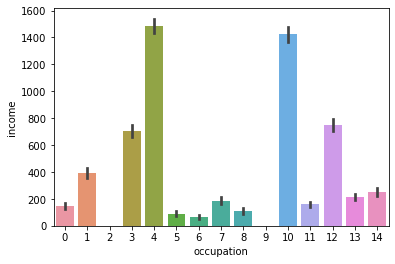

In [7]:
sns.barplot(x='occupation',y='income',data=EDA1,estimator=sum)

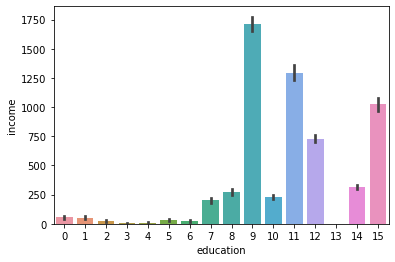

In [8]:
sns.barplot(x='education',y='income',data=EDA1,estimator=sum)

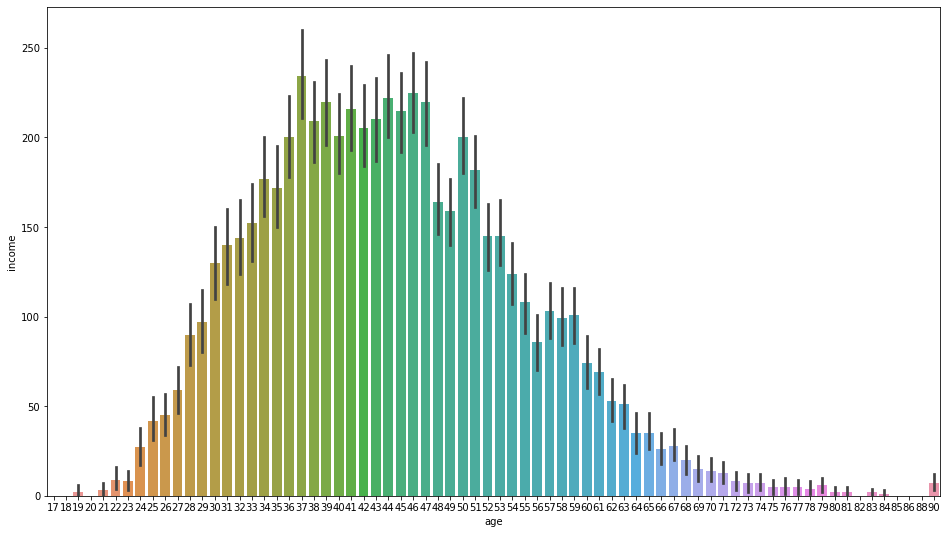

In [9]:
a=sns.barplot(x='age',y='income',data=EDA1,estimator=sum)
a.figure.set_size_inches(16,9)

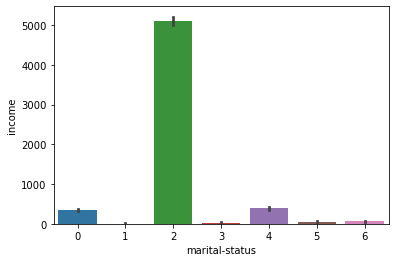

In [10]:
sns.barplot(x='marital-status',y='income',data=EDA1,estimator=sum)

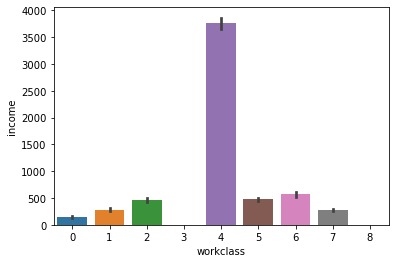

In [11]:
sns.barplot(x='workclass',y='income',data=EDA1,estimator=sum)

In [12]:
data1=data
EDA2=pd.get_dummies(data1)

In [13]:
table1=EDA1.corr().sort_values('income',ascending=False)
table1['income']

income            1.000000
education-num     0.333539
age               0.230700
hours-per-week    0.227305
capital-gain      0.222510
sex               0.216744
capital-loss      0.147657
occupation        0.076817
race              0.073077
education         0.071532
workclass         0.055015
native-country    0.016642
demogweight      -0.008029
marital-status   -0.198008
relationship     -0.251006
Name: income, dtype: float64

In [ ]:
table=EDA2.corr().sort_values('income_>50K.',ascending=False)
table['income_>50K.']

#### Massive Correlation Matrics

In [15]:
corr = EDA2.corr()
corr.style.background_gradient(cmap='coolwarm')

,age,workclass,demogweight,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
age,1.000000,0.008177,-0.075810,-0.015288,0.032765,-0.263989,-0.015555,-0.260526,0.027069,0.084250,0.073591,0.056408,0.069045,-0.002499,0.230700
workclass,0.008177,1.000000,-0.013327,0.020791,0.052213,-0.064131,0.254039,-0.091820,0.048674,0.097349,0.030435,0.016066,0.141320,-0.008880,0.055015
demogweight,-0.075810,-0.013327,1.000000,-0.027546,-0.043853,0.029521,0.001245,0.010333,-0.020728,0.029492,0.004366,-0.012152,-0.015179,-0.050835,-0.008029
education,-0.015288,0.020791,-0.027546,1.000000,0.356520,-0.034734,-0.024293,-0.005428,0.011934,-0.031968,0.031156,0.014886,0.046071,0.065595,0.071532
education-num,0.032765,0.052213,-0.043853,0.356520,1.000000,-0.066305,0.110272,-0.095476,0.031503,0.015325,0.120998,0.078483,0.145903,0.049267,0.333539
marital-status,-0.263989,-0.064131,0.029521,-0.034734,-0.066305,1.000000,-0.015288,0.180593,-0.068641,-0.127836,-0.046271,-0.034631,-0.194108,-0.021026,-0.198008
occupation,-0.015555,0.254039,0.001245,-0.024293,0.110272,-0.015288,1.000000,-0.081583,0.009514,0.083463,0.025865,0.020143,0.084114,-0.013004,0.076817
relationship,-0.260526,-0.091820,0.010333,-0.005428,-0.095476,0.180593,-0.081583,1.000000,-0.116666,-0.582218,-0.058577,-0.059890,-0.249706,-0.010928,-0.251006
race,0.027069,0.048674,-0.020728,0.011934,0.031503,-0.068641,0.009514,-0.116666,1.000000,0.086851,0.010893,0.016526,0.040777,0.135892,0.073077
sex,0.084250,0.097349,0.029492,-0.031968,0.015325,-0.127836,0.083463,-0.582218,0.086851,1.000000,0.046675,0.047298,0.231300,-0.006655,0.216744


In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   age             25000 non-null  int64
 1   workclass       25000 non-null  int32
 2   demogweight     25000 non-null  int64
 3   education       25000 non-null  int32
 4   education-num   25000 non-null  int64
 5   marital-status  25000 non-null  int32
 6   occupation      25000 non-null  int32
 7   relationship    25000 non-null  int32
 8   race            25000 non-null  int32
 9   sex             25000 non-null  int32
 10  capital-gain    25000 non-null  int64
 11  capital-loss    25000 non-null  int64
 12  hours-per-week  25000 non-null  int64
 13  native-country  25000 non-null  int32
 14  income          25000 non-null  int32
dtypes: int32(9), int64(6)
memory usage: 2.0 MB


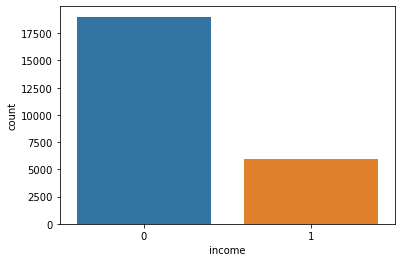

In [19]:
#fig, ax = plt.subplots(figsize=(20,6))
sns.countplot(data = data, x = "income")

## Data Preprocessing

In [24]:
data = pd.read_csv("USCensusTraining.csv")
test_data = pd.read_csv("USCensusTest.csv")

In [25]:
data['native-country'] = np.where(data["native-country"]=="United-States", "US", "others")

In [26]:
# drop "education" as it's repetitive with "education_num"
data = data.drop(["education"], axis = 1)

In [27]:
# number encoding on categorical variables
cat_cols = ["workclass", "marital-status", "occupation", "relationship", "race", "sex", "native-country"]
data = pd.get_dummies(data=data, columns=cat_cols) 

In [28]:
data = data.drop(["workclass_?", "marital-status_Divorced", "occupation_?", "relationship_Husband", 
                  "race_Other", "sex_Female", "native-country_others"], axis = 1)

In [29]:
data["income"] = np.where(data["income"]==">50K.", 1, 0)

In [30]:
X = data.drop("income", axis=1)
y = data["income"]

In [31]:
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

#save the scaler
import pickle as pkl
with open("scaler.pkl", "wb") as outfile:
    pkl.dump(scaler, outfile)

In [32]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=1)

## Model Development

### Baseline Model

In [33]:
model = Sequential()
model.add(Dense(12, input_dim=45, kernel_initializer='uniform', activation='relu'))
model.add(Dense(1, kernel_initializer='uniform', activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=50, batch_size = 10, verbose=1)

Epoch 1/50
2000/2000 [==============================] - 1s 540us/step - loss: 0.4826 - accuracy: 0.7774
Epoch 2/50
2000/2000 [==============================] - 1s 527us/step - loss: 0.3708 - accuracy: 0.8230
Epoch 3/50
2000/2000 [==============================] - 1s 530us/step - loss: 0.3632 - accuracy: 0.8294
Epoch 4/50
2000/2000 [==============================] - 1s 531us/step - loss: 0.3541 - accuracy: 0.8354
Epoch 5/50
2000/2000 [==============================] - 1s 533us/step - loss: 0.3538 - accuracy: 0.8352
Epoch 6/50
2000/2000 [==============================] - 1s 531us/step - loss: 0.3487 - accuracy: 0.8379
Epoch 7/50
2000/2000 [==============================] - 1s 543us/step - loss: 0.3559 - accuracy: 0.8350
Epoch 8/50
2000/2000 [==============================] - 1s 538us/step - loss: 0.3538 - accuracy: 0.8411
Epoch 9/50
2000/2000 [==============================] - 1s 669us/step - loss: 0.3414 - accuracy: 0.8466
Epoch 10/50
2000/2000 [==============================] - 1s 530u

In [34]:
_, accuracy = model.evaluate(X_valid, y_valid)
print('Accuracy: %.2f' % (accuracy*100) + '%')

157/157 [==============================] - 0s 473us/step - loss: 0.3425 - accuracy: 0.8476
Accuracy: 84.76%


### Hyper-parameter Tuning  (GridSearchCV)

In [35]:
def create_model(n_hidden = 1, neurons = 45, activation = "relu"):
    model = Sequential()
    for layer in range(n_hidden):
        model.add(Dense(neurons, input_dim = 45, kernel_initializer="uniform", activation=activation))
    model.add(Dense(1, kernel_initializer="uniform", activation="sigmoid"))
    model.compile(loss = "binary_crossentropy", optimizer = "rmsprop", metrics = ["accuracy"])
    return model

In [ ]:
checkpoint_cb = ModelCheckpoint("Checkpoints/ANN_1000ep_ES_CV.h5")
early_stopping_cb = EarlyStopping(monitor = "val_loss", mode = "min", patience = 10, restore_best_weights=True)

param_grid = {"n_hidden": [1, 2, 3],
              "neurons": [15, 20, 30, 45],
              "activation": ["relu", "tanh", "sigmoid"]}

model = KerasClassifier(build_fn=create_model, epochs = 1000, batch_size = 10, verbose = 1)
grid = GridSearchCV(estimator=model, param_grid=param_grid)
grid_result = grid.fit(X_train, y_train, epochs=1000, batch_size = 10, verbose=1,
                   validation_data = (X_valid, y_valid),
                   callbacks = [checkpoint_cb, early_stopping_cb])

Epoch 1/1000
1600/1600 [==============================] - 2s 908us/step - loss: 0.4894 - accuracy: 0.7701 - val_loss: 0.3813 - val_accuracy: 0.8076
Epoch 2/1000
1600/1600 [==============================] - 2s 1ms/step - loss: 0.3821 - accuracy: 0.8163 - val_loss: 0.3717 - val_accuracy: 0.8202
Epoch 3/1000
1600/1600 [==============================] - 1s 752us/step - loss: 0.3691 - accuracy: 0.8228 - val_loss: 0.3729 - val_accuracy: 0.8168
Epoch 4/1000
1600/1600 [==============================] - 1s 729us/step - loss: 0.3639 - accuracy: 0.8288 - val_loss: 0.3645 - val_accuracy: 0.8248
Epoch 5/1000
1600/1600 [==============================] - 1s 887us/step - loss: 0.3696 - accuracy: 0.8256 - val_loss: 0.3624 - val_accuracy: 0.8252
Epoch 6/1000
1600/1600 [==============================] - 1s 783us/step - loss: 0.3591 - accuracy: 0.8332 - val_loss: 0.3618 - val_accuracy: 0.8242
Epoch 7/1000
1600/1600 [==============================] - 1s 709us/step - loss: 0.3618 - accuracy: 0.8311 - val_lo

C:\Users\GloriaHou\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\GloriaHou\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\GloriaHou\anaconda3\lib\site-packages\tensorflow\python\keras\wrappers\scikit_learn.py", line 223, in fit
    return super(KerasClassifier, self).fit(x, y, **kwargs)
  File "C:\Users\GloriaHou\anaconda3\lib\site-packages\tensorflow\python\keras\wrappers\scikit_learn.py", line 166, in fit
    history = self.model.fit(x, y, **fit_args)
  File "C:\Users\GloriaHou\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py", line 1145, in fit
    callbacks.on_epoch_end(epoch, epoch_logs)
  File "C:\Users\GloriaHou\anaconda3\lib\site-package

1600/1600 [==============================] - 3s 1ms/step - loss: 0.4776 - accuracy: 0.7809 - val_loss: 0.3767 - val_accuracy: 0.8228
Epoch 2/1000
1600/1600 [==============================] - 1s 724us/step - loss: 0.3722 - accuracy: 0.8262 - val_loss: 0.3673 - val_accuracy: 0.8256
Epoch 3/1000
1600/1600 [==============================] - 1s 707us/step - loss: 0.3669 - accuracy: 0.8347 - val_loss: 0.3663 - val_accuracy: 0.8236
Epoch 4/1000
1600/1600 [==============================] - 1s 697us/step - loss: 0.3634 - accuracy: 0.8338 - val_loss: 0.3620 - val_accuracy: 0.8294
Epoch 5/1000
1600/1600 [==============================] - 1s 692us/step - loss: 0.3502 - accuracy: 0.8412 - val_loss: 0.3594 - val_accuracy: 0.8342
Epoch 6/1000
1600/1600 [==============================] - 1s 697us/step - loss: 0.3466 - accuracy: 0.8390 - val_loss: 0.3584 - val_accuracy: 0.8318
Epoch 7/1000
1600/1600 [==============================] - 2s 1ms/step - loss: 0.3509 - accuracy: 0.8384 - val_loss: 0.3581 - va

In [ ]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

In [ ]:
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with %r" % (mean, stdev, param))

The best set of parameter is n_hidden=2, neurons=45, and activation = "relu". So, we fitted the model with such such hyper-parameter below (in Best Performing Model section).

#### Best Performing Model

In [48]:
checkpoint_cb = ModelCheckpoint("Checkpoints/ANN_2HLys_45neurons_1000ep_ES.h5")
early_stopping_cb = EarlyStopping(monitor = "val_loss", mode = "min", patience = 10, restore_best_weights=True)

model1 = create_model(n_hidden=2, neurons=45, activation="relu")

history1 = model1.fit(X_train, y_train, epochs=1000, batch_size = 10, verbose=1,
                   validation_data = (X_valid, y_valid),
                   callbacks = [checkpoint_cb, early_stopping_cb])

model1.save("Models/ANN_2HLyr_45neurons_10BS_1000ep_ES10.h5")

Epoch 1/1000
2000/2000 [==============================] - 2s 754us/step - loss: 0.4324 - accuracy: 0.7959 - val_loss: 0.3753 - val_accuracy: 0.8162
Epoch 2/1000
2000/2000 [==============================] - 1s 715us/step - loss: 0.3647 - accuracy: 0.8297 - val_loss: 0.3599 - val_accuracy: 0.8388
Epoch 3/1000
2000/2000 [==============================] - 2s 765us/step - loss: 0.3579 - accuracy: 0.8395 - val_loss: 0.3554 - val_accuracy: 0.8400
Epoch 4/1000
2000/2000 [==============================] - 1s 734us/step - loss: 0.3522 - accuracy: 0.8416 - val_loss: 0.3518 - val_accuracy: 0.8432
Epoch 5/1000
2000/2000 [==============================] - 1s 701us/step - loss: 0.3486 - accuracy: 0.8471 - val_loss: 0.3532 - val_accuracy: 0.8416
Epoch 6/1000
2000/2000 [==============================] - 1s 698us/step - loss: 0.3501 - accuracy: 0.8453 - val_loss: 0.3467 - val_accuracy: 0.8448
Epoch 7/1000
2000/2000 [==============================] - 1s 712us/step - loss: 0.3448 - accuracy: 0.8464 - val_

In [51]:
_, accuracy = model1.evaluate(X_valid, y_valid)
print('Accuracy: %.2f' % (accuracy*100) + '%')

157/157 [==============================] - 0s 767us/step - loss: 0.3368 - accuracy: 0.8472
Accuracy: 84.72%


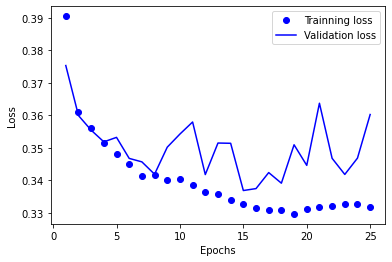

In [54]:
loss = history1.history['loss']
val_loss = history1.history['val_loss']

epochs = range(1, len(loss)+1)

plt.plot(epochs, loss, 'bo', label = 'Trainning loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()


plt.show()

### Parameter Tuning on a more constrained space (to avoid having large model variace)

In [73]:
checkpoint_cb = ModelCheckpoint("Checkpoints/ANN_1000ep_ES_CV.h5")
early_stopping_cb = EarlyStopping(monitor = "val_loss", mode = "min", patience = 10, restore_best_weights=True)

param_grid = {"n_hidden": [1, 2],
              "neurons": [10, 15, 20, 25, 30]}

model = KerasClassifier(build_fn=create_model, epochs = 1000, batch_size = 10, verbose = 1)
grid = GridSearchCV(estimator=model, param_grid=param_grid)
grid_result = grid.fit(X_train, y_train, epochs=1000, batch_size = 10, verbose=1,
                   validation_data = (X_valid, y_valid),
                   callbacks = [checkpoint_cb, early_stopping_cb])

Epoch 1/1000
1600/1600 [==============================] - 2s 798us/step - loss: 0.4954 - accuracy: 0.7718 - val_loss: 0.3776 - val_accuracy: 0.8168
Epoch 2/1000
1600/1600 [==============================] - 1s 700us/step - loss: 0.3771 - accuracy: 0.8180 - val_loss: 0.3711 - val_accuracy: 0.8236
Epoch 3/1000
1600/1600 [==============================] - 1s 673us/step - loss: 0.3744 - accuracy: 0.8146 - val_loss: 0.3683 - val_accuracy: 0.8292
Epoch 4/1000
1600/1600 [==============================] - 1s 800us/step - loss: 0.3640 - accuracy: 0.8287 - val_loss: 0.3643 - val_accuracy: 0.8240
Epoch 5/1000
1600/1600 [==============================] - 1s 830us/step - loss: 0.3649 - accuracy: 0.8286 - val_loss: 0.3616 - val_accuracy: 0.8252
Epoch 6/1000
1600/1600 [==============================] - 1s 825us/step - loss: 0.3565 - accuracy: 0.8337 - val_loss: 0.3606 - val_accuracy: 0.8288
Epoch 7/1000
1600/1600 [==============================] - 1s 787us/step - loss: 0.3584 - accuracy: 0.8307 - val_

C:\Users\GloriaHou\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\GloriaHou\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\GloriaHou\anaconda3\lib\site-packages\tensorflow\python\keras\wrappers\scikit_learn.py", line 223, in fit
    return super(KerasClassifier, self).fit(x, y, **kwargs)
  File "C:\Users\GloriaHou\anaconda3\lib\site-packages\tensorflow\python\keras\wrappers\scikit_learn.py", line 166, in fit
    history = self.model.fit(x, y, **fit_args)
  File "C:\Users\GloriaHou\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py", line 1145, in fit
    callbacks.on_epoch_end(epoch, epoch_logs)
  File "C:\Users\GloriaHou\anaconda3\lib\site-package

1600/1600 [==============================] - 2s 1ms/step - loss: 0.4978 - accuracy: 0.7703 - val_loss: 0.3776 - val_accuracy: 0.8178
Epoch 2/1000
1600/1600 [==============================] - 1s 715us/step - loss: 0.3651 - accuracy: 0.8302 - val_loss: 0.3691 - val_accuracy: 0.8218
Epoch 3/1000
1600/1600 [==============================] - 1s 685us/step - loss: 0.3564 - accuracy: 0.8329 - val_loss: 0.3655 - val_accuracy: 0.8244
Epoch 4/1000
1600/1600 [==============================] - 1s 675us/step - loss: 0.3552 - accuracy: 0.8356 - val_loss: 0.3625 - val_accuracy: 0.8238
Epoch 5/1000
1600/1600 [==============================] - 1s 670us/step - loss: 0.3564 - accuracy: 0.8350 - val_loss: 0.3616 - val_accuracy: 0.8244
Epoch 6/1000
1600/1600 [==============================] - 1s 691us/step - loss: 0.3574 - accuracy: 0.8361 - val_loss: 0.3583 - val_accuracy: 0.8296
Epoch 7/1000
1600/1600 [==============================] - 1s 745us/step - loss: 0.3590 - accuracy: 0.8355 - val_loss: 0.3569 - 

In [74]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: 0.852800 using {'n_hidden': 2, 'neurons': 20}


In [75]:
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with %r" % (mean, stdev, param))

nan (nan) with {'n_hidden': 1, 'neurons': 10}
0.848450 (0.004670) with {'n_hidden': 1, 'neurons': 15}
0.846600 (0.008143) with {'n_hidden': 1, 'neurons': 20}
nan (nan) with {'n_hidden': 1, 'neurons': 25}
0.850200 (0.004354) with {'n_hidden': 1, 'neurons': 30}
0.846500 (0.007048) with {'n_hidden': 2, 'neurons': 10}
0.849750 (0.006405) with {'n_hidden': 2, 'neurons': 15}
0.852800 (0.004885) with {'n_hidden': 2, 'neurons': 20}
0.849800 (0.003941) with {'n_hidden': 2, 'neurons': 25}
0.849450 (0.005881) with {'n_hidden': 2, 'neurons': 30}


### Final Model

In [55]:
early_stopping_cb = EarlyStopping(monitor = "val_loss", mode = "min", patience = 10, restore_best_weights=True)

final_model = create_model(n_hidden=2, neurons=20, activation="relu")

history2 = final_model.fit(X_train, y_train, epochs=1000, batch_size = 10, verbose=1,
                   validation_data = (X_valid, y_valid),
                   callbacks = [early_stopping_cb])

final_model.save("Models/ANN_2HLyr_20neurons_10BS_1000ep_ES10.h5")

Epoch 1/1000
2000/2000 [==============================] - 2s 837us/step - loss: 0.4520 - accuracy: 0.7861 - val_loss: 0.3745 - val_accuracy: 0.8168
Epoch 2/1000
2000/2000 [==============================] - 2s 1ms/step - loss: 0.3716 - accuracy: 0.8245 - val_loss: 0.3637 - val_accuracy: 0.8282
Epoch 3/1000
2000/2000 [==============================] - 2s 992us/step - loss: 0.3600 - accuracy: 0.8329 - val_loss: 0.3618 - val_accuracy: 0.8342
Epoch 4/1000
2000/2000 [==============================] - 3s 1ms/step - loss: 0.3634 - accuracy: 0.8299 - val_loss: 0.3572 - val_accuracy: 0.8320
Epoch 5/1000
2000/2000 [==============================] - 2s 1ms/step - loss: 0.3500 - accuracy: 0.8414 - val_loss: 0.3586 - val_accuracy: 0.8382
Epoch 6/1000
2000/2000 [==============================] - 2s 791us/step - loss: 0.3543 - accuracy: 0.8371 - val_loss: 0.3543 - val_accuracy: 0.8332
Epoch 7/1000
2000/2000 [==============================] - 2s 922us/step - loss: 0.3550 - accuracy: 0.8354 - val_loss: 

In [56]:
_, accuracy = final_model.evaluate(X_valid, y_valid)
print('Accuracy: %.2f' % (accuracy*100) + '%')

157/157 [==============================] - 0s 783us/step - loss: 0.3382 - accuracy: 0.8514
Accuracy: 85.14%


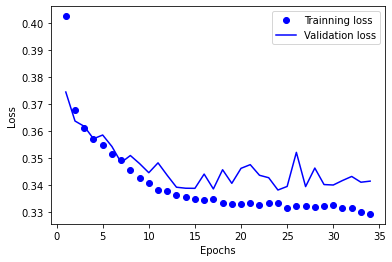

In [58]:
loss = history2.history['loss']
val_loss = history2.history['val_loss']

epochs = range(1, len(loss)+1)

plt.plot(epochs, loss, 'bo', label = 'Trainning loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [59]:
early_stopping_cb = EarlyStopping(monitor = "val_loss", mode = "min", patience = 10, restore_best_weights=True)

final_model = create_model(n_hidden=2, neurons=20, activation="relu")

history2 = final_model.fit(X, y, epochs=1000, batch_size = 10, verbose=1,
                   validation_data = (X, y),
                   callbacks = [early_stopping_cb])

final_model.save("final_model.h5")

Epoch 1/1000
2500/2500 [==============================] - 4s 1ms/step - loss: 0.4430 - accuracy: 0.7939 - val_loss: 0.3688 - val_accuracy: 0.8230
Epoch 2/1000
2500/2500 [==============================] - 3s 1ms/step - loss: 0.3688 - accuracy: 0.8247 - val_loss: 0.3650 - val_accuracy: 0.8327
Epoch 3/1000
2500/2500 [==============================] - 3s 1ms/step - loss: 0.3728 - accuracy: 0.8244 - val_loss: 0.3552 - val_accuracy: 0.8323
Epoch 4/1000
2500/2500 [==============================] - 5s 2ms/step - loss: 0.3589 - accuracy: 0.8348 - val_loss: 0.3514 - val_accuracy: 0.8387
Epoch 5/1000
2500/2500 [==============================] - 4s 2ms/step - loss: 0.3587 - accuracy: 0.8352 - val_loss: 0.3484 - val_accuracy: 0.8411
Epoch 6/1000
2500/2500 [==============================] - 3s 1ms/step - loss: 0.3512 - accuracy: 0.8404 - val_loss: 0.3417 - val_accuracy: 0.8455
Epoch 7/1000
2500/2500 [==============================] - 4s 2ms/step - loss: 0.3438 - accuracy: 0.8479 - val_loss: 0.3399 -

## Making Predictions

In [60]:
test_data['native-country'] = np.where(test_data["native-country"]=="United-States", "US", "others")

# drop "education" as it's repetitive with "education_num"
test_data = test_data.drop(["education"], axis = 1)

# number encoding on categorical variables
cat_cols = ["workclass", "marital-status", "occupation", "relationship", "race", "sex", "native-country"]
test_data = pd.get_dummies(data=test_data, columns=cat_cols)

test_data = test_data.drop(["workclass_?", "marital-status_Divorced", "occupation_?", "relationship_Husband", 
                  "race_Other", "sex_Female", "native-country_others"], axis = 1)


In [61]:
with open("scaler.pkl", "rb") as infile:
    scaler = pkl.load(infile)
    test_data_X_scaled = scaler.transform(test_data)

In [62]:
#final_model = load_model("final_model.h5")

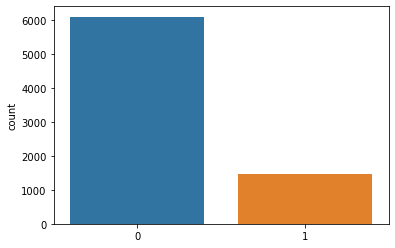

In [63]:
predictions = (final_model.predict(test_data_X_scaled) > 0.5).astype("int8").astype("object").flatten()

sns.countplot(predictions)

In [64]:
np.savetxt(r'4predictions.txt', predictions, fmt="%s", encoding="utf-8")

## Feature Importance

In [66]:
model = load_model("final_model.h5")

In [67]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 46 columns):
 #   Column                                Non-Null Count  Dtype
---  ------                                --------------  -----
 0   age                                   25000 non-null  int64
 1   demogweight                           25000 non-null  int64
 2   education-num                         25000 non-null  int64
 3   capital-gain                          25000 non-null  int64
 4   capital-loss                          25000 non-null  int64
 5   hours-per-week                        25000 non-null  int64
 6   income                                25000 non-null  int32
 7   workclass_Federal-gov                 25000 non-null  uint8
 8   workclass_Local-gov                   25000 non-null  uint8
 9   workclass_Never-worked                25000 non-null  uint8
 10  workclass_Private                     25000 non-null  uint8
 11  workclass_Self-emp-inc                250

In [68]:
# Evaluate Feature Importance:
Features = np.identity(X_train.shape[1], dtype = float) 
Features = Features[[0,1,3,4,5]] # only the variables ("age", "demogweight", "capital-gain", "capital-loss", "hours-per-week") are numeric
Importance = model.predict(Features)
Feature_names = np.asarray(['age', 'demogweight', 'capital-gain', 'capital-loss', 'hours-per-week'])
FeatureImportance = pd.DataFrame(Importance, Feature_names)
FeatureImportance.columns = ['Importances']
FeatureImportance = FeatureImportance.sort_values(by='Importances', ascending=False)
FeatureImportance

,Importances
capital-gain,1.000000
capital-loss,0.345975
hours-per-week,0.140898
demogweight,0.124538
age,0.114438


In [69]:
x_most = data[['capital-gain','income']]
min_max_scaler = MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x_most.values)
x_most = pd.DataFrame(x_scaled, columns=x_most.columns)

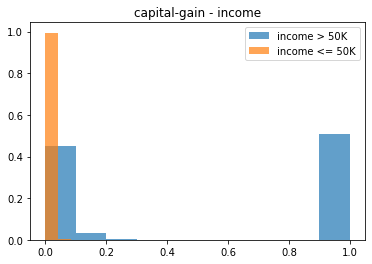

In [70]:
# Subsetting
subset1 = x_most[x_most['income'] == 1]
subset0 = x_most[x_most['income'] == 0]

input_data = [np.asarray(subset1).flatten(),np.asarray(subset0).flatten()]
weight1 = np.ones(len(input_data[0])) / len(input_data[0])
weight2 = np.ones(len(input_data[1])) / len(input_data[1])

plt.figure()
plt.hist(np.asarray(subset1).flatten(), weights = weight1, alpha=0.7, label='income > 50K')
plt.hist(np.asarray(subset0).flatten(), weights = weight2, alpha=0.7, label='income <= 50K')
plt.legend(prop={'size': 10})
plt.title('capital-gain - income')
plt.savefig('capital-gain - income.png')
plt.show()

In [ ]:
x_least = data[['age', 'income']]
x_scaled = min_max_scaler.fit_transform(x_least.values)
x_least = pd.DataFrame(x_scaled, columns=x_least.columns)

In [ ]:
# Subsetting
subset1 = x_least[x_least['income'] == 1]
subset0 = x_least[x_least['income'] == 0]

input_data = [np.asarray(subset1).flatten(),np.asarray(subset0).flatten()]
weight1 = np.ones(len(input_data[0])) / len(input_data[0])
weight2 = np.ones(len(input_data[1])) / len(input_data[1])

plt.figure()
plt.hist(np.asarray(subset1).flatten(), weights = weight1, alpha=0.7, label='income > 50K')
plt.hist(np.asarray(subset0).flatten(), weights = weight2, alpha=0.7, label='income <= 50K')
plt.legend(prop={'size': 10})
plt.title('age - income')
plt.savefig('age - income.png')
plt.show()